# ライブラリの読み込み

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set()

# データの読み込み

In [5]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

Survival：0 = No, 1 = Yes

In [6]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_raw.shape

(891, 12)

In [8]:
test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
test_raw.shape

(418, 11)

In [10]:
train = train_raw.copy()
test = test_raw.copy()

In [11]:
train = train.drop('Survived', axis=1)
train['Survived'] = train_raw['Survived']
train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


# 基礎集計

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

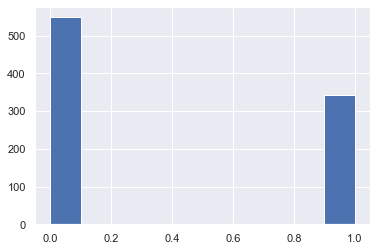

In [12]:
plt.hist(train['Survived'])

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

## s1生き残り・s0死亡で比較

In [15]:
train_s0 = train[train['Survived']==0]
train_s0.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
count,549.000000,549.000000,549,549,424.000000,549.000000,549.000000,549,549.000000,68,549,549.0
unique,NaN,NaN,549,2,NaN,NaN,NaN,470,NaN,62,3,NaN
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S,NaN
freq,NaN,NaN,1,468,NaN,NaN,NaN,7,NaN,2,427,NaN
mean,447.016393,2.531876,NaN,NaN,30.626179,0.553734,0.329690,NaN,22.117887,NaN,NaN,0.0
std,260.640469,0.735805,NaN,NaN,14.172110,1.288399,0.823166,NaN,31.388207,NaN,NaN,0.0
min,1.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.0
25%,211.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.854200,NaN,NaN,0.0
50%,455.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,10.500000,NaN,NaN,0.0
75%,675.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,26.000000,NaN,NaN,0.0


In [16]:
train_s1 = train[train['Survived']==1]
train_s1.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
count,342.000000,342.000000,342,342,290.000000,342.000000,342.000000,342,342.000000,136,340,342.0
unique,NaN,NaN,342,2,NaN,NaN,NaN,260,NaN,101,3,NaN
top,NaN,NaN,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,NaN,NaN,NaN,1601,NaN,B96 B98,S,NaN
freq,NaN,NaN,1,233,NaN,NaN,NaN,5,NaN,4,217,NaN
mean,444.368421,1.950292,NaN,NaN,28.343690,0.473684,0.464912,NaN,48.395408,NaN,NaN,1.0
std,252.358840,0.863321,NaN,NaN,14.950952,0.708688,0.771712,NaN,66.596998,NaN,NaN,0.0
min,2.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.0
25%,250.750000,1.000000,NaN,NaN,19.000000,0.000000,0.000000,NaN,12.475000,NaN,NaN,1.0
50%,439.500000,2.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,26.000000,NaN,NaN,1.0
75%,651.500000,3.000000,NaN,NaN,36.000000,1.000000,1.000000,NaN,57.000000,NaN,NaN,1.0


### age（年齢）

(array([36., 19., 63., 65., 52., 24., 21.,  9.,  0.,  1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

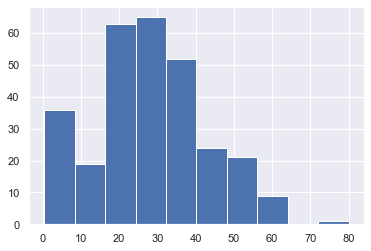

In [17]:
plt.hist(train_s1['Age'])

(array([ 18.,  16.,  99., 110.,  64.,  45.,  38.,  15.,  13.,   6.]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <BarContainer object of 10 artists>)

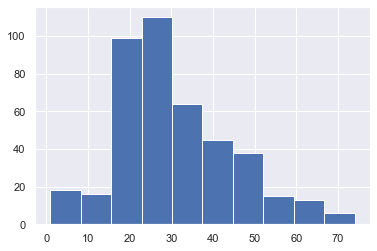

In [18]:
plt.hist(train_s0['Age'])

### Pclass（Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)）

(array([136.,   0.,   0.,   0.,   0.,  87.,   0.,   0.,   0., 119.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

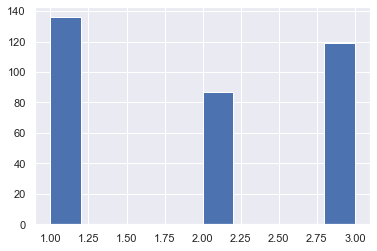

In [19]:
plt.hist(train_s1['Pclass'])

(array([ 80.,   0.,   0.,   0.,   0.,  97.,   0.,   0.,   0., 372.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

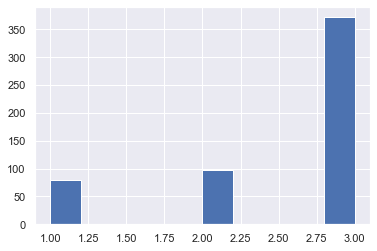

In [20]:
plt.hist(train_s0['Pclass'])

### sex（Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)）

(array([233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 109.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

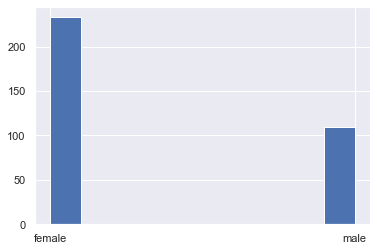

In [21]:
plt.hist(train_s1['Sex'])

(array([468.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  81.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

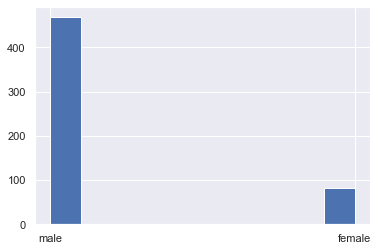

In [22]:
plt.hist(train_s0['Sex'])

### sibsp（Number of Siblings/Spouses Aboard）

Number of Siblings/Spouses Aboard　⇒　一緒に乗船した兄弟、配偶者の数

(array([210.,   0., 112.,   0.,   0.,  13.,   0.,   4.,   0.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

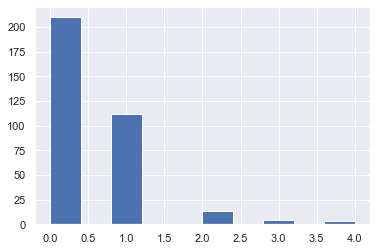

In [23]:
plt.hist(train_s1['SibSp'])

(array([398.,  97.,  15.,  12.,   0.,  15.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

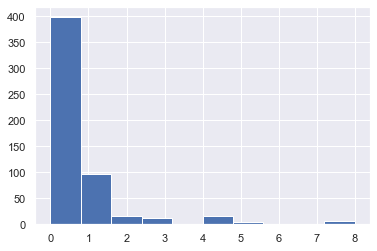

In [24]:
plt.hist(train_s0['SibSp'])

### parch（Number of Parents/Children Aboard）

Number of Parents/Children Aboard　⇒　一緒に乗船した親子の数

(array([233.,   0.,  65.,   0.,  40.,   0.,   3.,   0.,   0.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

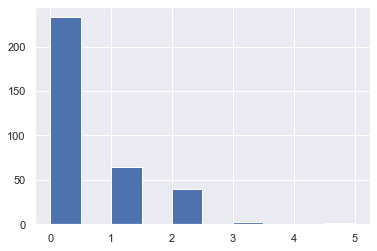

In [25]:
plt.hist(train_s1['Parch'])

(array([445.,  53.,   0.,  40.,   0.,   2.,   4.,   0.,   4.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

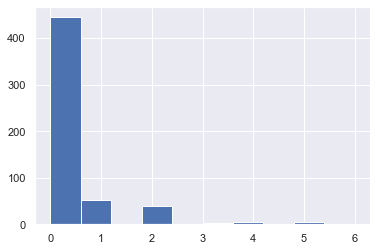

In [26]:
plt.hist(train_s0['Parch'])

### fare（Passenger fare）

(array([233.,  70.,  23.,   2.,   7.,   4.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

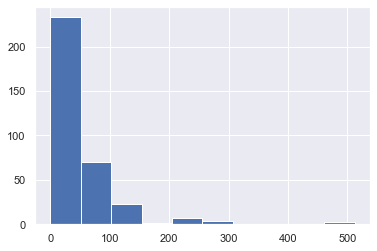

In [27]:
plt.hist(train_s1['Fare'])

(array([421.,  83.,  25.,   6.,   4.,   4.,   0.,   0.,   3.,   3.]),
 array([  0. ,  26.3,  52.6,  78.9, 105.2, 131.5, 157.8, 184.1, 210.4,
        236.7, 263. ]),
 <BarContainer object of 10 artists>)

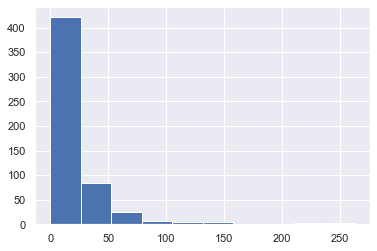

In [28]:
plt.hist(train_s0['Fare'])

### embarked（Port of Embarkation）

In [29]:
print('生き残り：C = Cherbourg→',len(train_s1[train_s1['Embarked']=='C']))
print('生き残り：Q = Queenstown→',len(train_s1[train_s1['Embarked']=='Q']))
print('生き残り：S = Southampton→',len(train_s1[train_s1['Embarked']=='S']))

生き残り：C = Cherbourg→ 93
生き残り：Q = Queenstown→ 30
生き残り：S = Southampton→ 217


In [30]:
print('死亡：C = Cherbourg→',len(train_s0[train_s0['Embarked']=='C']))
print('死亡：Q = Queenstown→',len(train_s0[train_s0['Embarked']=='Q']))
print('死亡：S = Southampton→',len(train_s0[train_s0['Embarked']=='S']))

死亡：C = Cherbourg→ 75
死亡：Q = Queenstown→ 47
死亡：S = Southampton→ 427


# 前処理

## 欠損地処理

In [31]:
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [32]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### ageの欠損値処理

In [33]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [34]:
test['Age'] = test['Age'].fillna(test['Age'].median())

In [35]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 文字列データを数値に変換

In [36]:
# male=0,female=1に変換
train['Sex'][train['Sex'] == 'male'] = 0
train['Sex'][train['Sex'] == 'female'] = 1
test['Sex'][test['Sex'] == 'male'] = 0
test['Sex'][test['Sex'] == 'female'] = 1

C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\2262783174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'][train['Sex'] == 'male'] = 0
C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\2262783174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'][train['Sex'] == 'female'] = 1
C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\2262783174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sex'][test

In [37]:
train['Sex']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: object

In [38]:
# S(Southampton)=0,C(Cherbourg)=1, Q(Queenstown)=2
train["Embarked"][train["Embarked"] == "S" ] = 0
train["Embarked"][train["Embarked"] == "C" ] = 1
train["Embarked"][train["Embarked"] == "Q"] = 2
test["Embarked"][test["Embarked"] == "S" ] = 0
test["Embarked"][test["Embarked"] == "C" ] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2

C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\3827633073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Embarked"][train["Embarked"] == "S" ] = 0
C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\3827633073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Embarked"][train["Embarked"] == "C" ] = 1
C:\Users\09de1\AppData\Local\Temp\ipykernel_17228\3827633073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

In [39]:
train['Embarked']

0      0
1      1
2      0
3      0
4      0
      ..
886    0
887    0
888    0
889    1
890    2
Name: Embarked, Length: 891, dtype: object

In [40]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0


In [41]:
features_col = ['Pclass', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch', 'Embarked']

train_y = train['Survived'].values
train_X = train[features_col].values

In [42]:
print(train_y.shape)
print(train_X.shape)

(891,)
(891, 7)


# xgboost

## GridSearchCVによるパラメータチューニング

In [43]:
from xgboost import XGBClassifier

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
parameters = {
    'n_estimators':[i for i in range(10, 100, 10)],
    'learning_rate':[10, 1, 0.1, 0.01],
    'max_depth':[i for i in range(1, 5, 1)],
    'random_state':[3],
}

In [46]:
clf = GridSearchCV(XGBClassifier(), parameters, cv=5)

In [47]:
clf.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [10, 1, 0.1, 0.01],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'random_state': [3]})

In [48]:
clf.best_params_

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 60, 'random_state': 3}

In [49]:
clf.best_score_

0.8395518172117254

In [50]:
from xgboost import XGBClassifier

In [51]:
model_XGB = XGBClassifier(max_depth=2, learning_rate=1, n_estimators=60, random_state=3)

In [52]:
model_XGB.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, ...)

In [53]:
model_XGB.score(train_X, train_y)

0.9090909090909091

## 予測

In [54]:
test_X = test[features_col].values

In [55]:
prediction = model_XGB.predict(test_X)

In [56]:
prediction.shape

(418,)

In [57]:
print(prediction)

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1
 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1
 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [58]:
sub = pd.read_csv('titanic/gender_submission.csv', index_col=None)
sub.head()

FileNotFoundError: [Errno 2] No such file or directory: 'titanic/gender_submission.csv'

In [ ]:
sub['Survived'] = prediction

In [ ]:
sub.to_csv('titanic_xgboost.csv', index=False)

## 特徴量の重要度可視化

### 可視化①

In [ ]:
plt.barh(train[features_col].columns.values, model_XGB.feature_importances_)

### 可視化②

In [ ]:
feature_important = model_XGB.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### 可視化③

In [59]:
from xgboost import plot_importance

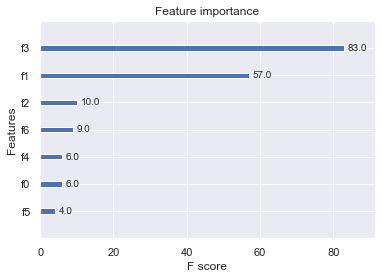

In [60]:
plot_importance(model_XGB)
plt.show()

### 可視化④

In [61]:
feature_imp = pd.Series(model_XGB.feature_importances_, index=train[features_col].columns.values).sort_values(ascending=False)

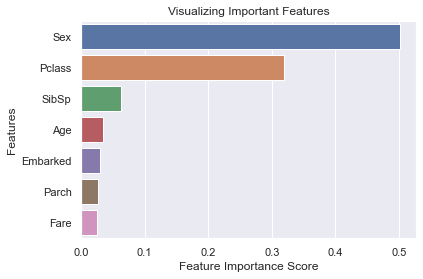

In [62]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
# plt.legend()
plt.show()

### 可視化④

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

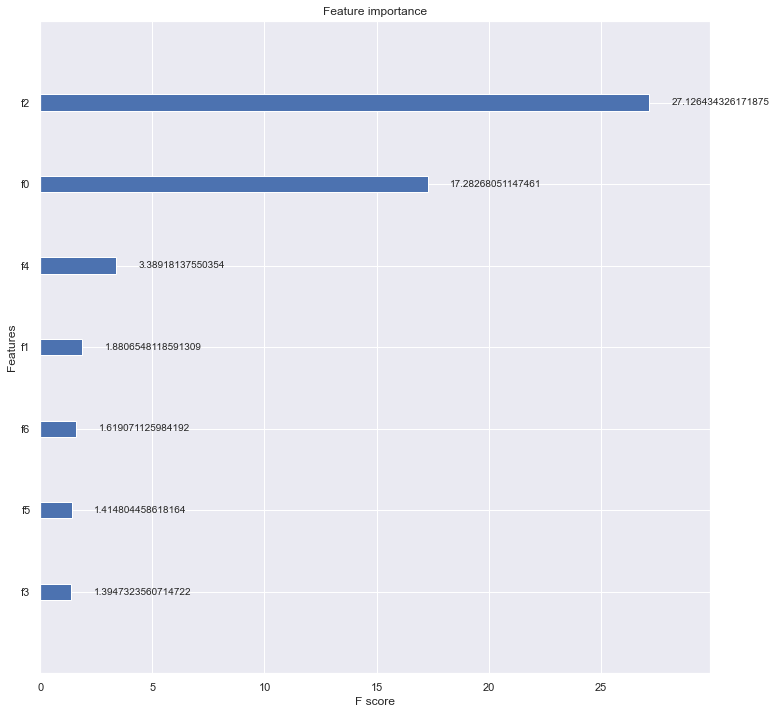

In [63]:
_, ax = plt.subplots(figsize=(12, 12))
plot_importance(model_XGB.get_booster(),
                ax=ax,
                importance_type='gain')

## 決定木の可視化

### 可視化①

In [64]:
from dtreeviz.trees import *

In [65]:
import graphviz

In [66]:
type(train[features_col])

pandas.core.frame.DataFrame

In [67]:
viz = dtreeviz(model_XGB,
               x_data=train[features_col],
               y_data=train['Survived'],
               target_name='y',
               feature_names=train[features_col].columns.tolist(),
               tree_index=0)

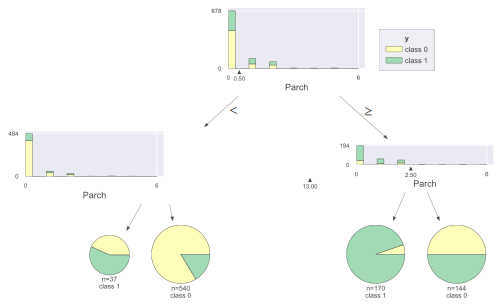

In [68]:
display(viz)

In [69]:
viz.save('xgb_tree.svg')

### 可視化②

In [70]:
from xgboost import plot_tree

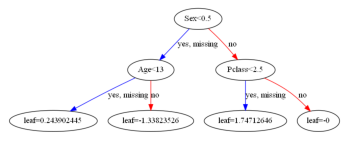

In [71]:
plot_tree(model_XGB, figsize=(20, 20))
plt.show()

### 可視化③

In [72]:
import xgboost as xgb

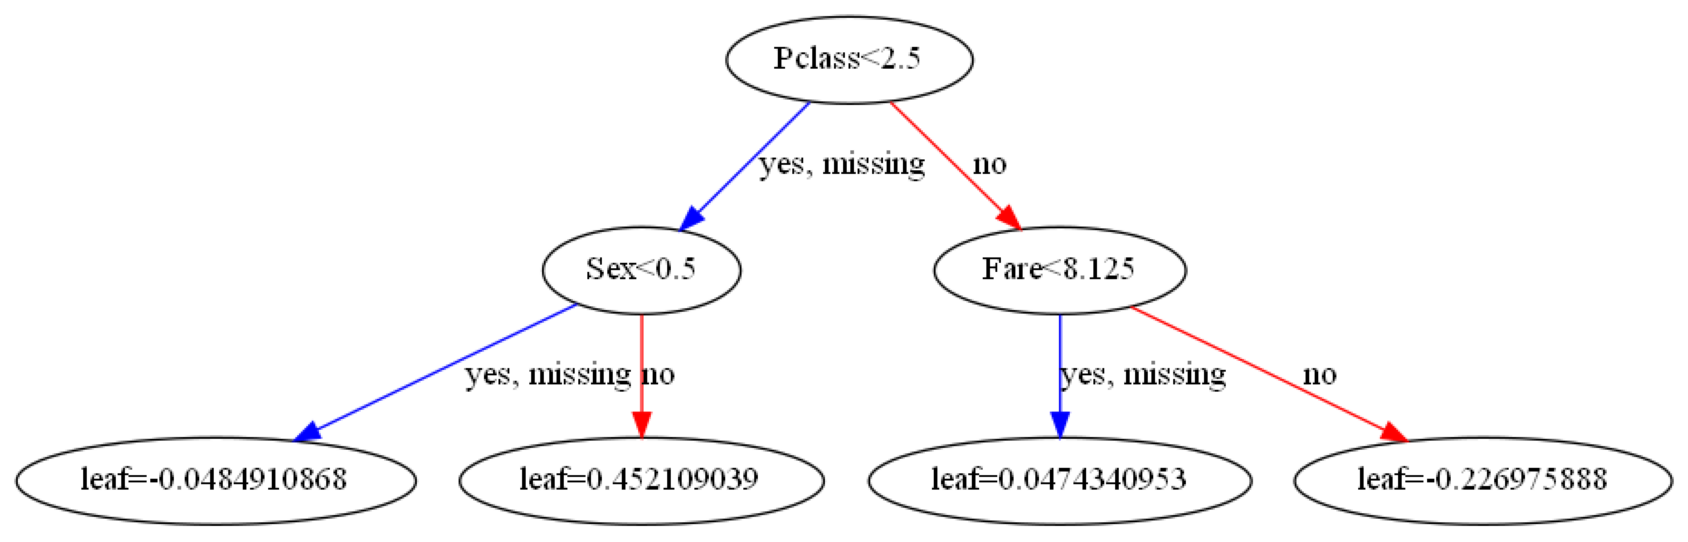

In [73]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model_XGB, num_trees=10, ax=ax)
plt.show()

### 可視化④

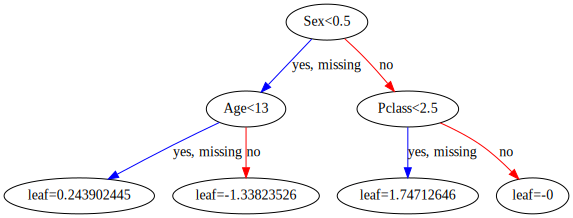

In [74]:
xgb.to_graphviz(model_XGB, num_trees=0)